In [1]:
from __future__ import absolute_import, division, print_function
import numpy as np
import collections
import math
import os
import random
from six.moves import urllib
import io
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output, Image, display, HTML
import tensorflow as tf
import tensorflow_hub as hub
import sklearn.metrics as sk_metrics
import time
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from tensorflow.keras import backend as K
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from keras.applications import xception

In [2]:
## set train, validation, and test paths
train_path = '../input/datasetfinal/dataset70-10-20/train/Fruit'
validation_path = '../input/datasetfinal/dataset70-10-20/val/Fruit'
test_path = '../input/datasetfinal/dataset70-10-20/test/Fruit'

In [3]:
fruits_classes=[]
for root, subdirectories, files in os.walk(train_path):
    for subdirectory in subdirectories:
        fruits_classes.append(subdirectory)
print(len(fruits_classes))

28


In [4]:
train_batches  = ImageDataGenerator().flow_from_directory(
    train_path, target_size=(224, 224), classes = fruits_classes, batch_size = 50)

validation_batches  = ImageDataGenerator().flow_from_directory(
    validation_path, target_size=(224, 224), classes = fruits_classes, batch_size = 10)

test_batches  = ImageDataGenerator().flow_from_directory(
    test_path, target_size=(224, 224), classes = fruits_classes, batch_size = 10)

Found 1649 images belonging to 28 classes.
Found 224 images belonging to 28 classes.
Found 497 images belonging to 28 classes.


## Data Augmentation

In [5]:
## Augmentation datagenerator
train_datagen_aug = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest',
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

## train generator
train_generator_aug = train_datagen_aug.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=25,
        class_mode='categorical')

## test generator, required for prediction
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=1,
        shuffle = False,
        class_mode='categorical')

## validation generator
val_generator = test_datagen.flow_from_directory(
        validation_path,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

Found 1649 images belonging to 28 classes.
Found 497 images belonging to 28 classes.
Found 224 images belonging to 28 classes.


In [6]:
## set steps per epoch for train
train_filenames = train_generator_aug.filenames
steps_train = len(train_filenames)/train_generator_aug.batch_size

## set steps per epoch for validation
val_filenames = val_generator.filenames
steps_val = len(val_filenames)/val_generator.batch_size

## test
filenames_test = test_generator.filenames
nb_samples_test= len(filenames_test)
true_classes = test_generator.classes
target_names = fruits_classes

# Xception

In [7]:
model = xception.Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3),classes=28,pooling='avg')
model.summary()

2022-01-05 13:57:50.910484: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-05 13:57:51.002868: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-05 13:57:51.003612: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-05 13:57:51.004819: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

83697664/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________

In [8]:
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [9]:
count = 0
for layer in model.layers:
    count += 1
count

133

In [10]:
for layer in model.layers:
    layer.trainable = False
for layer in model.layers[-10:]:
    layer.trainable = True

In [11]:
x= model.output
x= tf.keras.layers.Dropout(.4)(x)
output=Dense(28,activation='softmax')(x)
fruits_xception= Model(model.input,output)

In [12]:
fruits_xception.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(1e-4),
              metrics=['acc'])

es = EarlyStopping(monitor='val_accuracy', min_delta=0.01,patience= 3, verbose=1)
mc = ModelCheckpoint("./fruits_best_xception.h5", monitor='val_accuracy', verbose=1, save_best_only=True)
cb=[es, mc]

fit_generator = fruits_xception.fit(train_generator_aug,
                                    steps_per_epoch=steps_train,
                                    epochs=50,
                                    validation_data=val_generator,
                                    validation_steps=steps_val,
                                    verbose=1,
                                    callbacks=cb)

2022-01-05 13:57:56.178333: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-01-05 13:58:00.311394: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


65/65 [==============================] - 37s 420ms/step - loss: 2.7776 - acc: 0.3396 - val_loss: 1.8154 - val_acc: 0.4821
Epoch 2/50
65/65 [==============================] - 22s 339ms/step - loss: 1.8171 - acc: 0.5713 - val_loss: 1.1430 - val_acc: 0.6027
Epoch 3/50
65/65 [==============================] - 23s 346ms/step - loss: 1.2375 - acc: 0.7029 - val_loss: 0.7359 - val_acc: 0.7723
Epoch 4/50
65/65 [==============================] - 23s 342ms/step - loss: 0.9125 - acc: 0.7890 - val_loss: 0.5344 - val_acc: 0.8125
Epoch 5/50
65/65 [==============================] - 22s 337ms/step - loss: 0.7113 - acc: 0.8326 - val_loss: 0.4197 - val_acc: 0.8616
Epoch 6/50
65/65 [==============================] - 22s 335ms/step - loss: 0.5622 - acc: 0.8751 - val_loss: 0.3480 - val_acc: 0.8839
Epoch 7/50
65/65 [==============================] - 23s 342ms/step - loss: 0.4925 - acc: 0.8678 - val_loss: 0.3173 - val_acc: 0.8795
Epoch 8/50
65/65 [==============================] - 23s 346ms/step - loss: 0.385

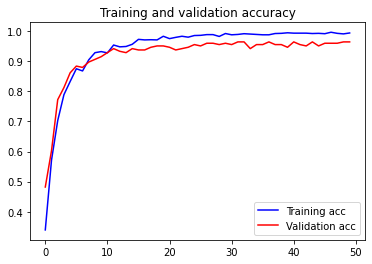

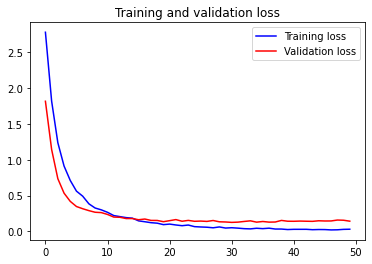

In [13]:
acc = fit_generator.history['acc']
val_acc = fit_generator.history['val_acc']
loss = fit_generator.history['loss']
val_loss = fit_generator.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [14]:
fruits_xception.save('fruits_xception.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [15]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(fruits_xception)
tflite_model = converter.convert()

# Save the model.
with open('fruits_xception.tflite', 'wb') as f:
    f.write(tflite_model)

2022-01-05 14:18:02.783651: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2022-01-05 14:18:15.129610: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-05 14:18:15.130001: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-01-05 14:18:15.130174: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-01-05 14:18:15.130676: I tensorflow/stream_executor/cuda/cuda_gpu_executor.

## Predict

In [16]:
fruits_pred= fruits_xception.predict(test_generator, steps = nb_samples_test, verbose=2)
fruits_pred= fruits_pred.argmax(axis=1)

497/497 - 5s


### Classification Report

In [17]:
print(classification_report(true_classes, fruits_pred, target_names=target_names))

                  precision    recall  f1-score   support

        Satsumas       1.00      1.00      1.00        16
       Pink-Lady       1.00      1.00      1.00        18
          Orange       1.00      1.00      1.00        20
      Royal-Gala       0.95      1.00      0.97        18
   Passion-Fruit       1.00      1.00      1.00        20
            Lime       0.93      0.93      0.93        14
   Red-Delicious       0.95      0.95      0.95        20
     Pomegranate       0.96      0.96      0.96        25
            Plum       1.00      1.00      1.00        16
       Pineapple       1.00      0.92      0.96        13
          Papaya       0.91      1.00      0.95        20
            Kiwi       0.95      0.95      0.95        19
  Red-Grapefruit       1.00      1.00      1.00        14
      Conference       1.00      1.00      1.00        14
       Nectarine       1.00      0.93      0.97        15
          Kaiser       0.92      0.92      0.92        25
    Granny-Sm